
![alt text](https://kaggle2.blob.core.windows.net/competitions/kaggle/4458/media/sfcrime_banner.png "Caption This")
## <center>San Francisco Crime Classification</center>
### <center> Emily Wang | Filippos Lymperopoulos</center>
### <center> Spring 2016</center>


## Abstract
Around the world, crime is fought by police resources. For the safety of any city, if the police is aware of *what* kinds of crimes are mainly going on, and what their distribution is over the city, they can identify *where* to target police resources and help alleviate crimes.

In this notebook, we will investigate and predict the category of crimes that took place in San Fransisco, CA from 2003 to 2015 based on a dataset derived from SFPD Crime Incident Reporting System. We developed several classification models including Gradient Descent, Random Forest, Stochastic Gradient Descent and Naive Bayes and compared them to different baseline models to interpret the effect of each. We further analyzed the pros and cons of each method and submitted our result to Kaggle, where we compared them with the public leaderboard raknings.

## The Problem

> From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

> Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

> From Sunset to SOMA, and Marina to Excelsior, this dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. 


Given the time and location, we will try to predict the category of crime that occurred.

## Introduction

Our plan is to predict the crime category based on the dataset provided from SFPD Crime Incident Reporting System. In the next section we are going to introduce the dataset we will be using in this experiment. In the sections to follow we will analytically state what features we will be extracting from the dataset, methods we took to approach such a multi-class problem and finally provide certain vizualizations that support our findings.   

## Dataset

In order to build our classifier, we used the afore-mentioned dataset from the SFPD Crime Incident Reporting system. The crime records exceed 800,000 in number and range from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to the test set, and week 2,4,6,8... belong to the training set. For each row of data, there are 9 columns:
- **Dates**: timestamp of the crime incident
- **Category**: category of the crime incident (only in train.csv).
This is the target variable we are going to predict.
- **Descript**: detailed description of the crime incident
(only in train.csv)
- **DayOfWeek**: the day of the week
- **PdDistrict**: Police Department District name
- **Resolution**: how the crime incident was resolved (only
in train.csv)
- **Address**: the approximate street address of the crime
incident
- **X**: Longitude
- **Y**: Latitude


Two example rows can be seen below using the train dataset we will be using.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.metrics import log_loss
import numpy as np
import pprint as pp

# Convert the Dates column of our provided data from string to datetime format.
train = pd.read_csv('train.csv', parse_dates = ['Dates'])
test = pd.read_csv('test.csv', parse_dates = ['Dates'])

# Returns first 2 rows
display(train.head(2))

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


There is a total of 39 different crime types in the dataset, among which larceny/theft, other offences, non-criminal, assault and drugs are the 5 most common ones. Their count distribution can be seen in the figure below. 

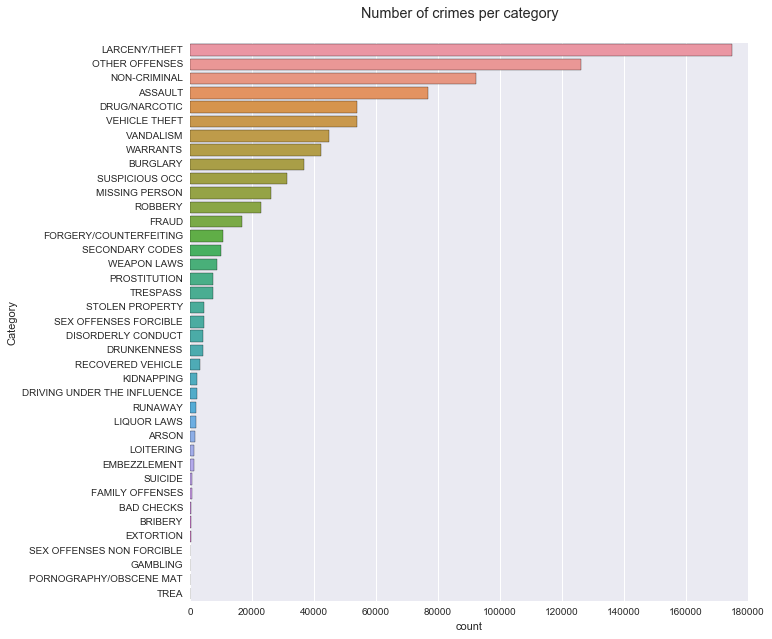

In [5]:
# Set the figure size
f = plt.figure(figsize=(10,10))
# Use the "Category" column from the train dataset and order based on count
sns.countplot(y="Category", data=train, order=train.Category.value_counts().index)
# Set figure title and dims
st = f.suptitle('Number of crimes per category', fontsize="x-large")
st.set_y(0.95)
f.subplots_adjust(top=0.9)

It is worth noting that the top 5 crimes constitute about 66% of the whole records, therefore, it can be assumed that it is reasonable to allocate more police resources in dealing with these crimes.

As part of our exploration analysis, we further looked into the the distribution of different crimes across different days of the week to get a better understanding of the effect at which day of the week affected the number of crimes recorded.

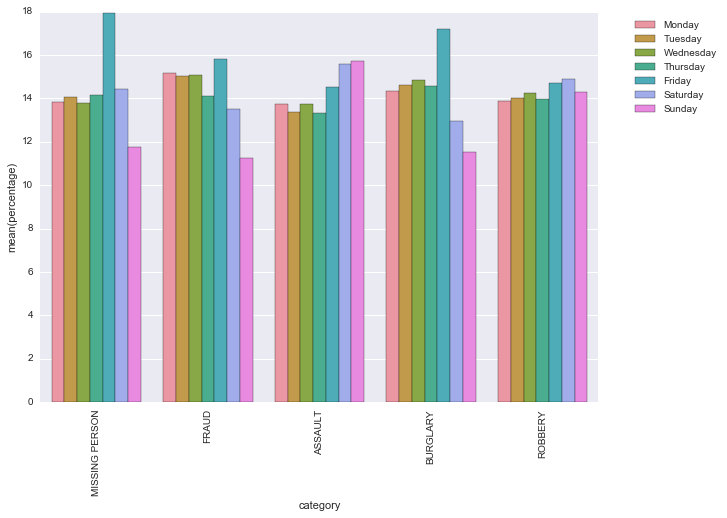

In [27]:
# Select categories to get displayed
cat_subset = ["ASSAULT", "BURGLARY", "MISSING PERSON", "ROBBERY", "FRAUD"]

# Grouped by crime category
grouped = train.groupby(['Category'], sort=False)

# Grouped by "day of the week" column
weekday_counts = grouped['DayOfWeek'].value_counts(normalize=True, sort=False)

# Normalize data on weekday crime data 
weekday_data = [
    {'category': category, 'DayOfWeek': DayOfWeek, 'percentage': percentage*100} 
    for (category, DayOfWeek), percentage in dict(weekday_counts).items() if category in cat_subset
]

# Get data for weekdays
df_weekday = pd.DataFrame(weekday_data)
# Sort weekday strings
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Display plot
p = plt.figure(figsize=(10,7))
p = sns.barplot(x='category', y='percentage', hue='DayOfWeek', data=df_weekday, hue_order=weekday_order)
_ = plt.setp(p.get_xticklabels(), rotation=90) 
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Meanwhile, we were very interested in seeing how the most frequent crime type; i.e. "Larceny/theft" broke down into more specific categories and better understand what this "theft" phenomenon really meant. The relevant lengthy code along with several other vizualizations on this exploration can be found [here](https://github.com/flymperopoulos/DataScience16CYOA/blob/master/data_exploration.ipynb).

## Feature Engineering - Preprocessing

One of our goals for this project was to make our code readable and, above all accessible for others to use as an API framework. As a resuly, we made an SFP class via which one can:
- Extract the time features one wants to use for the model (i.e. year, season, month, day etc.)
- Encode categorical variables in a meaningful way: API contains a preprocessor that can both transform and inverse_transform the categorical variables
- Return a transformed dataframe to be given to the model


In [28]:
# SFP = SFCrime Preprocessor
class SFP():
    def __init__(self, data):
        self.data = data
        self.Y_encoder = preprocessing.LabelEncoder()
    
    # Prepare inputs
    def prep_district(self):
        # one hot encoding
        return pd.get_dummies(self.data.PdDistrict)
    
    def prep_hour(self):
        # a continuous value from 0 to 23
        return self.data.Dates.dt.hour # Gets the hour portion form the "Dates" column
    
    def prep_day(self):
        # one hot encoding
        return pd.get_dummies(self.data.DayOfWeek)
    
    def prep_years(self):
        # beware: 2015 has significantly less incidents than the other years in this dataset.        
        pass
    
    def concat_features(self):
        hour = self.prep_hour()
        day = self.prep_day()
        district = self.prep_district()
        return pd.concat([hour, day, district], axis=1)
    
    # Encode or decode classes
    def encode_Y(self, Y):
        return self.Y_encoder.fit_transform(Y)

    def decode_Y(self, encoded_Y):
        return self.Y_encoder.inverse_transform(encoded_Y)

## Data Partitioning

An important part of our exploration was finding out the best way to utilize and "break down" our train dataset, so that we could test a variety of altrernate models and, at the same time, not overfit or underfit the data with our predictions. We split our data training dataset into two subset; i.e. training (X_train, y_train) and validation (X_test, y_test), as shown below.

In [31]:
from sklearn.cross_validation import train_test_split

sfp = SFP(train)
X = sfp.concat_features()
y = sfp.encode_Y(train.Category)
X.rename(columns = {'Dates':'Hour'}, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

Our dataset contains approximately 800,000 rows of data, and getting the chance to further partition our training dataset (60% of the total dataset), allows us to explore different validation procedures.

## A Multi-Class Problem

As we mentioned earlier, the dataset contains 39 different types of crime and, as a result, when trying to predict a crime class for a given time and location, we will have to consider the evaluation of our models in terms of a logarithmic-loss expression. Log-loss measures the accuracy of a classifier and it suits our case, as it is used when the model outputs a probability for each class, rather than just the most likely class. Such an output will incorporate the idea of probabilistic confidenceand can be thought of as the *cross entropy* between the distribution of the true labels and the predictions. The smaller the cross entropy (log-loss value), the more accurate our classifier is going to be.

### Multi class log-loss

Let's take for example the application of a Random Forest Classifier to our model. We are instantiating the RandomForestClassifier by specifying a specific split size and by fitting our train data we can make predictions on our training data. As a result, using the *predict_proba* method by sklearn, we are able to obtain a column matrix of probabilities for each incident and then compute the log-loss value of each class referenced to that truth.

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Using some hyperparameter values from DataQuest mission 75
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=1) 
_ = rf.fit(X_train, y_train)
y_predictions = rf.predict_proba(X_test)
rf_log_loss = log_loss(y_test, y_predictions)
print "Random Forest's log-loss score is", rf_log_loss

Random Forest's log-loss score is 3.01115581032


### Per class log-loss

It is known that each incident recorded in the dataset is labeled with one "true" class. In addition to that we developed the suspicion that our model is doing better on the classes that have more incidents recorded, i.e. LARCENY/THEFT has many thousands more data points than ASSAULT. To investigate which classes our current multi-class model does poorly on, we are computing the per-class log loss for each class.

In order to make our model's output compatible for per class log loss calculatuions, we had to do some processing of the y vectors into 1s and 0s. We are going to implement an SGC classifier for the example code below as the provider for our y_predictions.

In [48]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", penalty="l2", n_iter = 10)
_ = sgd.fit(X_train, y_train)
y_predictions = sgd.predict_proba(X_test)
sgd_log_loss = log_loss(y_test, y_predictions)

def compute_per_class_log_loss(y_predictions, y_test):
    # returns a 39-element list of the per_class_log_loss 
    # (one value per class. the index of the element corresponds with the class numbebr)
    per_class_log_loss = []
    for c in range(0, 39):
        current_class = y_predictions[:, c]
        not_current_class = 1 - y_predictions[:, c]

        df = pd.DataFrame({
                "truth" : y_test,
                "current_class" : current_class,
                "not_current_class" : not_current_class
            })

        df.loc[df["truth"] == c, "binary_truth"] = 1
        df.loc[df["truth"] != c, "binary_truth"] = 0

        y_binary_truth = np.array(df["binary_truth"])
        y_binary_predictions = np.array(pd.concat([df["current_class"], df["not_current_class"]], axis=1))

        current_class_log_loss = log_loss(y_binary_truth, y_binary_predictions)
        per_class_log_loss.append(current_class_log_loss)
    return per_class_log_loss

per_class_log_loss = compute_per_class_log_loss(y_predictions, y_test)

Let's plot the output per_class values on a scatter plot for a quick overview of the 39 values for per class log loss.


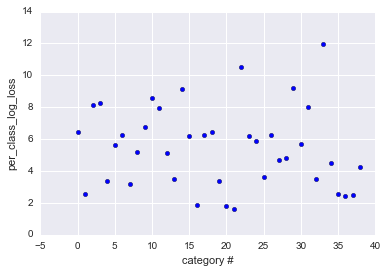

In [49]:
plt.scatter(range(0,39), per_class_log_loss)
plt.xlabel("category #")
plt.ylabel("per_class_log_loss")
plt.show()

It turns out that our NB model is worst at predicting class 33 (TREA) and 22 (PORNOGRAHY/OBSCENE MAT) and is the best at predicting the most common classes 16 (LARCENY/THEFT) and 1 (ASSAULT). Classes 33 and 22 also happen to be the categories with the least amount of incidents in the training dataset.

For instance, it was interesting to note that the classes our Stochastic Gradient Descent model was doing worst on classifying correctly the following crime classes.

In [51]:
def sorted_perclass_logloss(labelstrs, log_losses):
    spl = []
    for i in range(len(labelstrs)):
        spl.append([labels[i], "CLASS " + str(i), log_losses[i]])
    spl = sorted(spl, key=lambda x: x[2]) # sort by the class' log loss value (the 2nd element in the list within)
    return spl

def n_highest_perclass_logloss(spl, n=39):
    # if no n is specified, this function returns the entire list sorted from highest to lowest perclass logloss
    reversed_spl = list(reversed(spl))
    return reversed_spl[0:n]


labels = sfp.decode_Y(sgd.classes_)
spl = sorted_perclass_logloss(labels, per_class_log_loss)

pp.pprint(n_highest_perclass_logloss(spl, 5))


[['TREA', 'CLASS 33', 11.964708621415413],
 ['PORNOGRAPHY/OBSCENE MAT', 'CLASS 22', 10.502020572355409],
 ['SEX OFFENSES NON FORCIBLE', 'CLASS 29', 9.2231326958154334],
 ['GAMBLING', 'CLASS 14', 9.1657817765320342],
 ['EXTORTION', 'CLASS 10', 8.5917634678686277]]


While it was performing on classifying best the following.

In [54]:
def n_lowest_perclass_logloss(spl, n=39):
    # if no n is specified, this function returns the entire list sorted from lowest to highest perclass logloss
    # spl is already in order from lowest to highest perclass logloss value
    return spl[0:n]
pp.pprint(n_lowest_perclass_logloss(spl, 5))

[['OTHER OFFENSES', 'CLASS 21', 1.6315763519366953],
 ['NON-CRIMINAL', 'CLASS 20', 1.7926100892102372],
 ['LARCENY/THEFT', 'CLASS 16', 1.8877152442937681],
 ['VEHICLE THEFT', 'CLASS 36', 2.4547698337706669],
 ['WARRANTS', 'CLASS 37', 2.5157016758051123]]


## Interpreting log-loss

In this problem, using log-loss to interpret the accuracy of our models makes sense. It is a multi-class problem that requires us to obtain outputs in a form of a probability distribution. Adding on to this, it has to be pointed out that we don't have a very good intuition on what log-loss really means: it's difficult to just "eyeball" a log loss value and determine whether it is decent or bad; in contrast it is easy for us to realize that 15% accuracy is terrible compared to 99% accuracy). In order for us to better understand what log-loss means we compared a model iteration's log-loss values to a baseline's log loss values. As a result, we were able to get a better understanding of model performance.

For instance, we computed the per-class log-loss with different classifiers (Stochastic Gradient Descent, Random Forest etc.) and compared them to the baseline's per-class log-loss to see if our models are performing better.

Below is an image of a per-class log loss model performance comparison plot. It's somewhat squished in this notebook; we recommend opening it in a new tab (via the right click menu) or looking at the file in the GitHub repo. See the code and accompanying commentary in the model_iter_7_final.ipynb notebook for the details.

![](pcll_comparisons.png)

In the plot above, the overall trend is that the green bars representing the per class log loss from our random forest are drastically larger than the bars from the baseline model and the naive bayes model. This visualization helps drive next action items for predictive models, such as finding different feature engineering methods to make the features more friendly to random forests, deciding to continue working with the naive bayes model and learning more about how to make features more compatible with the naive bayes model, and so on.

## Conclusion

We started this project by performing feature engineering and preprocessing of the data provided by the SFPD Crime Incident Reporting system. We proceeded by modifying our dataframe and providing it with certain features to represent specific attributes of our data (i.e. time broken into say, hour etc.). We then explored the area of log-loss implementation and, finally, got to train some a variety of models with the features we employed to determine the probability of occurance of a certain crime given a location (district) and time. 

As shown in our exploration notebook, different models perform in different ways and produce flactuating log-loss values. Naive Bayes and Stochastic Gradient Descent performed descently, although there is a lot of exploration to be further done on tweaking hyperparameters of the methods to achieve a lower log-loss score. Log-loss proved to be an adequate way of measuring the accuracy of such a multi-class problem.

Certainly a way to improve our classifier would be to include more feaures from the dataset provided by the SFPD C.I.R. In addition to that, alterations to our preprocessor would allow us to handle more complicated calls to the dataset and, hence, manipulate it in ways where more features could be used. 